# Exercise 9

Alissa Trujillo<br>
August 2, 2022<br>
DSC 530<br>
Week 9: Time Series Analysis

### Exercise 12-1

In order to create a quadratic model to make predictions, we will first have to import the dataset and all of the underlying functions we needed to run the linear prediction model.

In [4]:
import numpy as np
import pandas as pd
import random

In [5]:
import thinkstats2
import thinkplot
import matplotlib

In [7]:
transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [10]:
def GroupByQualityAndDay(transactions):
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)
    
    return dailies

dailies = GroupByQualityAndDay(transactions)

In [13]:
def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)
    
    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year
    
    return daily

daily = GroupByDay(transactions, func=np.mean)

In [16]:
import statsmodels.formula.api as smf

In [17]:
def RunQuadraticModel(daily):
    daily["years2"] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

In [22]:
def PlotFittedValues(model, results, label=""):
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label="model", color="#ff7f00")

In [27]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunQuadraticModel):
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="gray")

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="gray")

In [30]:
def SimulateResults(daily, iters=101, func=RunQuadraticModel):
    _, results = func(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [32]:
def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)

    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

Now that we have imported everything we need, we can run our model.

In [18]:
RunQuadraticModel(daily)

(<statsmodels.regression.linear_model.OLS at 0x7f912c10cb50>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f912feb6f10>)

**Predictions: High Quality**

In [34]:
name = "high"
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Tue, 02 Aug 2022   Prob (F-statistic):          4.57e-164
Time:                        11:46:59   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

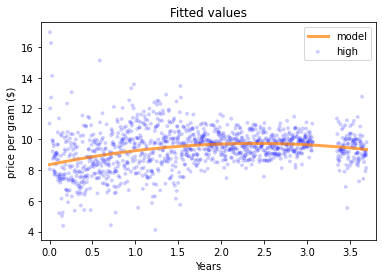

In [41]:
PlotFittedValues(model, results, label=name)
thinkplot.Config(
    title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8],
    ylabel="price per gram ($)")

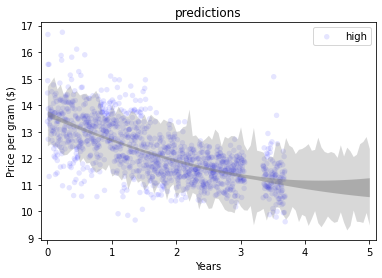

In [36]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(
    title="predictions",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)")

**Predictions: Medium Quality**

In [44]:
name = "medium"
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     57.33
Date:                Tue, 02 Aug 2022   Prob (F-statistic):           1.55e-24
Time:                        11:49:15   Log-Likelihood:                -2030.6
No. Observations:                1238   AIC:                             4067.
Df Residuals:                    1235   BIC:                             4083.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3509      0.104     80.512      0.000       8.147       8.554
years          1.1472      0.130      8.806      0.000       0.892       1.403
years2        -0.2386      0.035     -6.878      0.000      -0.307      -0.171
==============================================================================
Omnibus:                      194.417   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1123.295
Skew:                           0.585   Prob(JB):                    1.20e-244
Kurtosis:                       7.517   Cond. No.                         27.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

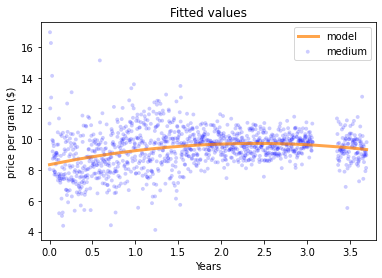

In [45]:
PlotFittedValues(model, results, label=name)
thinkplot.Config(
    title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8],
    ylabel="price per gram ($)")

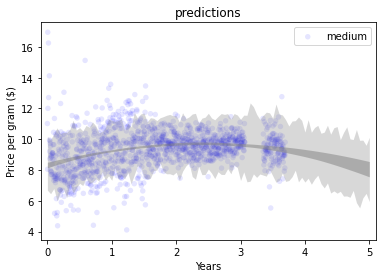

In [46]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(
    title="predictions",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)")

**Predictions: Low Quality**

In [47]:
name = "low"
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     22.86
Date:                Tue, 02 Aug 2022   Prob (F-statistic):           1.83e-10
Time:                        11:50:36   Log-Likelihood:                -3086.5
No. Observations:                1179   AIC:                             6179.
Df Residuals:                    1176   BIC:                             6194.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7050      0.287     16.393      0.000       4.142       5.268
years          1.6329      0.357      4.573      0.000       0.932       2.334
years2        -0.2937      0.095     -3.091      0.002      -0.480      -0.107
==============================================================================
Omnibus:                      661.159   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6718.787
Skew:                           2.415   Prob(JB):                         0.00
Kurtosis:                      13.651   Cond. No.                         28.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

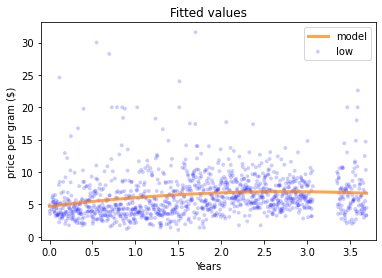

In [48]:
PlotFittedValues(model, results, label=name)
thinkplot.Config(
    title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8],
    ylabel="price per gram ($)")

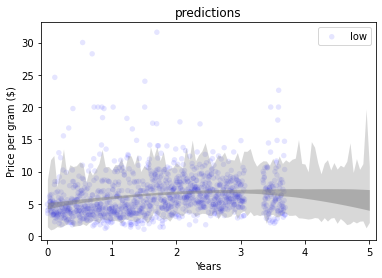

In [49]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(
    title="predictions",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)")

### Exercise 12-2

**Defining A Class**

In [50]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [52]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

**Testing Serial Correlation: High Quality**

In [53]:
name = "high"
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.485229376194738 0.0


The serial correlation between consecutive prices of high quality marijuana is 0.49. This means that they correlate positively with each other. The p-value is 0.0 meaning it is statistically significant.

**Testing Serial Correlation: Medium Quality**

In [54]:
name = "medium"
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.16006429989181087 0.0


The serial correlation between consecutive prices of high quality marijuana is 0.16. This means that they correlate positively with each other. The p-value is 0.0 meaning it is statistically significant.

**Testing Serial Correlation: Low Quality**

In [55]:
name = "low"
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.11657497441101058 0.0


The serial correlation between consecutive prices of high quality marijuana is 0.11. This means that they correlate positively with each other. The p-value is 0.0 meaning it is statistically significant.

**Testing Serial Correlation in Our Linear Model**

In [57]:
def RunLinearModel(daily):
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

In [59]:
GroupByDay(transactions, func=np.mean)

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.0895083713478188 0.001


The serial correlation of the residuals in our linear model is 0.90, meaning that they are highly positively correlated. The p-value is 0.001 meaning that it is statistically significant.

**Testing Serial Correlation in Our Quadratic Model**

In [61]:
_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.08222659370583411 0.006


The serial correlation of the residuals in our quadratic model is 0.82, meaning that they are positively correlated. The p-value is 0.006 meaning that it is statistically significant.